In [1]:
# Change working directory
%cd ..

d:\HUST\OT factorization\ot-kpgf


c:\Users\nguye\Apps\anaconda3\envs\ot-kpgf\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments._experiment import Experiment
from typing import Tuple, Optional, List, Union, Dict
import copy

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rcParams['figure.dpi'] = 300

plus_minus = u"\u00B1"
algo_id = {"KeypointFOT": "KFOT", "LOT": "LOT", "FOT": "FOT", "OT": "OT"}

def summarize(exp_name, records: List[Dict], y_axis, gt="usps_test"):
    record_ = copy.deepcopy(records[0])
    if "None" in record_.keys():
        record_["None"] = {k: [] for k in record_["None"]}
    for k, v in record_[exp_name].items():
        record_[exp_name][k] = {k_: [] for k_ in v}

    for record in records:
        if "None" in record_.keys():
            for k in record["None"]:
                record_["None"][k].append(record["None"][k])
        
        for k, v in record[exp_name].items():
            for metric in v.keys():
                record_[exp_name][k][metric].append(v[metric])

    for method in record_[exp_name].keys():
        record_[exp_name][method]["summary"] = {}
        if "None" in record_.keys():
            record_[exp_name][method]["summary"]["delta_acc"] = (np.array(record_[exp_name][method][y_axis]) - np.array(record_["None"][gt])[:, None]) / (1 - np.array(record_["None"][gt])[:, None])   
        else:
            record_[exp_name][method]["summary"]["delta_acc"] = np.array(record_[exp_name][method][y_axis])
        
        record_[exp_name][method]["summary"]["delta_acc_mean"] = record_[exp_name][method]["summary"]["delta_acc"].mean(axis=0)
        record_[exp_name][method]["summary"]["delta_acc_std"] = record_[exp_name][method]["summary"]["delta_acc"].std(axis=0)       

    return record_

def moving_average(arr, window):
    arr = arr[:-1] + [arr[-1] for _ in range(window)]
    return np.convolve(arr, np.ones(window), "valid") / window

--- Experiments ---

- DA: 
    - Robust to sampling: Đạt
    - DU-MNIST: Đạt
    - USPS-MNIST: Đạt
- Robustness
    - Dimensionality: ? (OT) -> L2
    - Cluster mismatch: Đạt
    - Outlier rate: ? (OT) -> L2
- Ablation:
    - Keypoint: Đạt
    - Alpha: Đạt
    - Eps: Đạt
    - Rho: Đạt

# Domain Adaptation

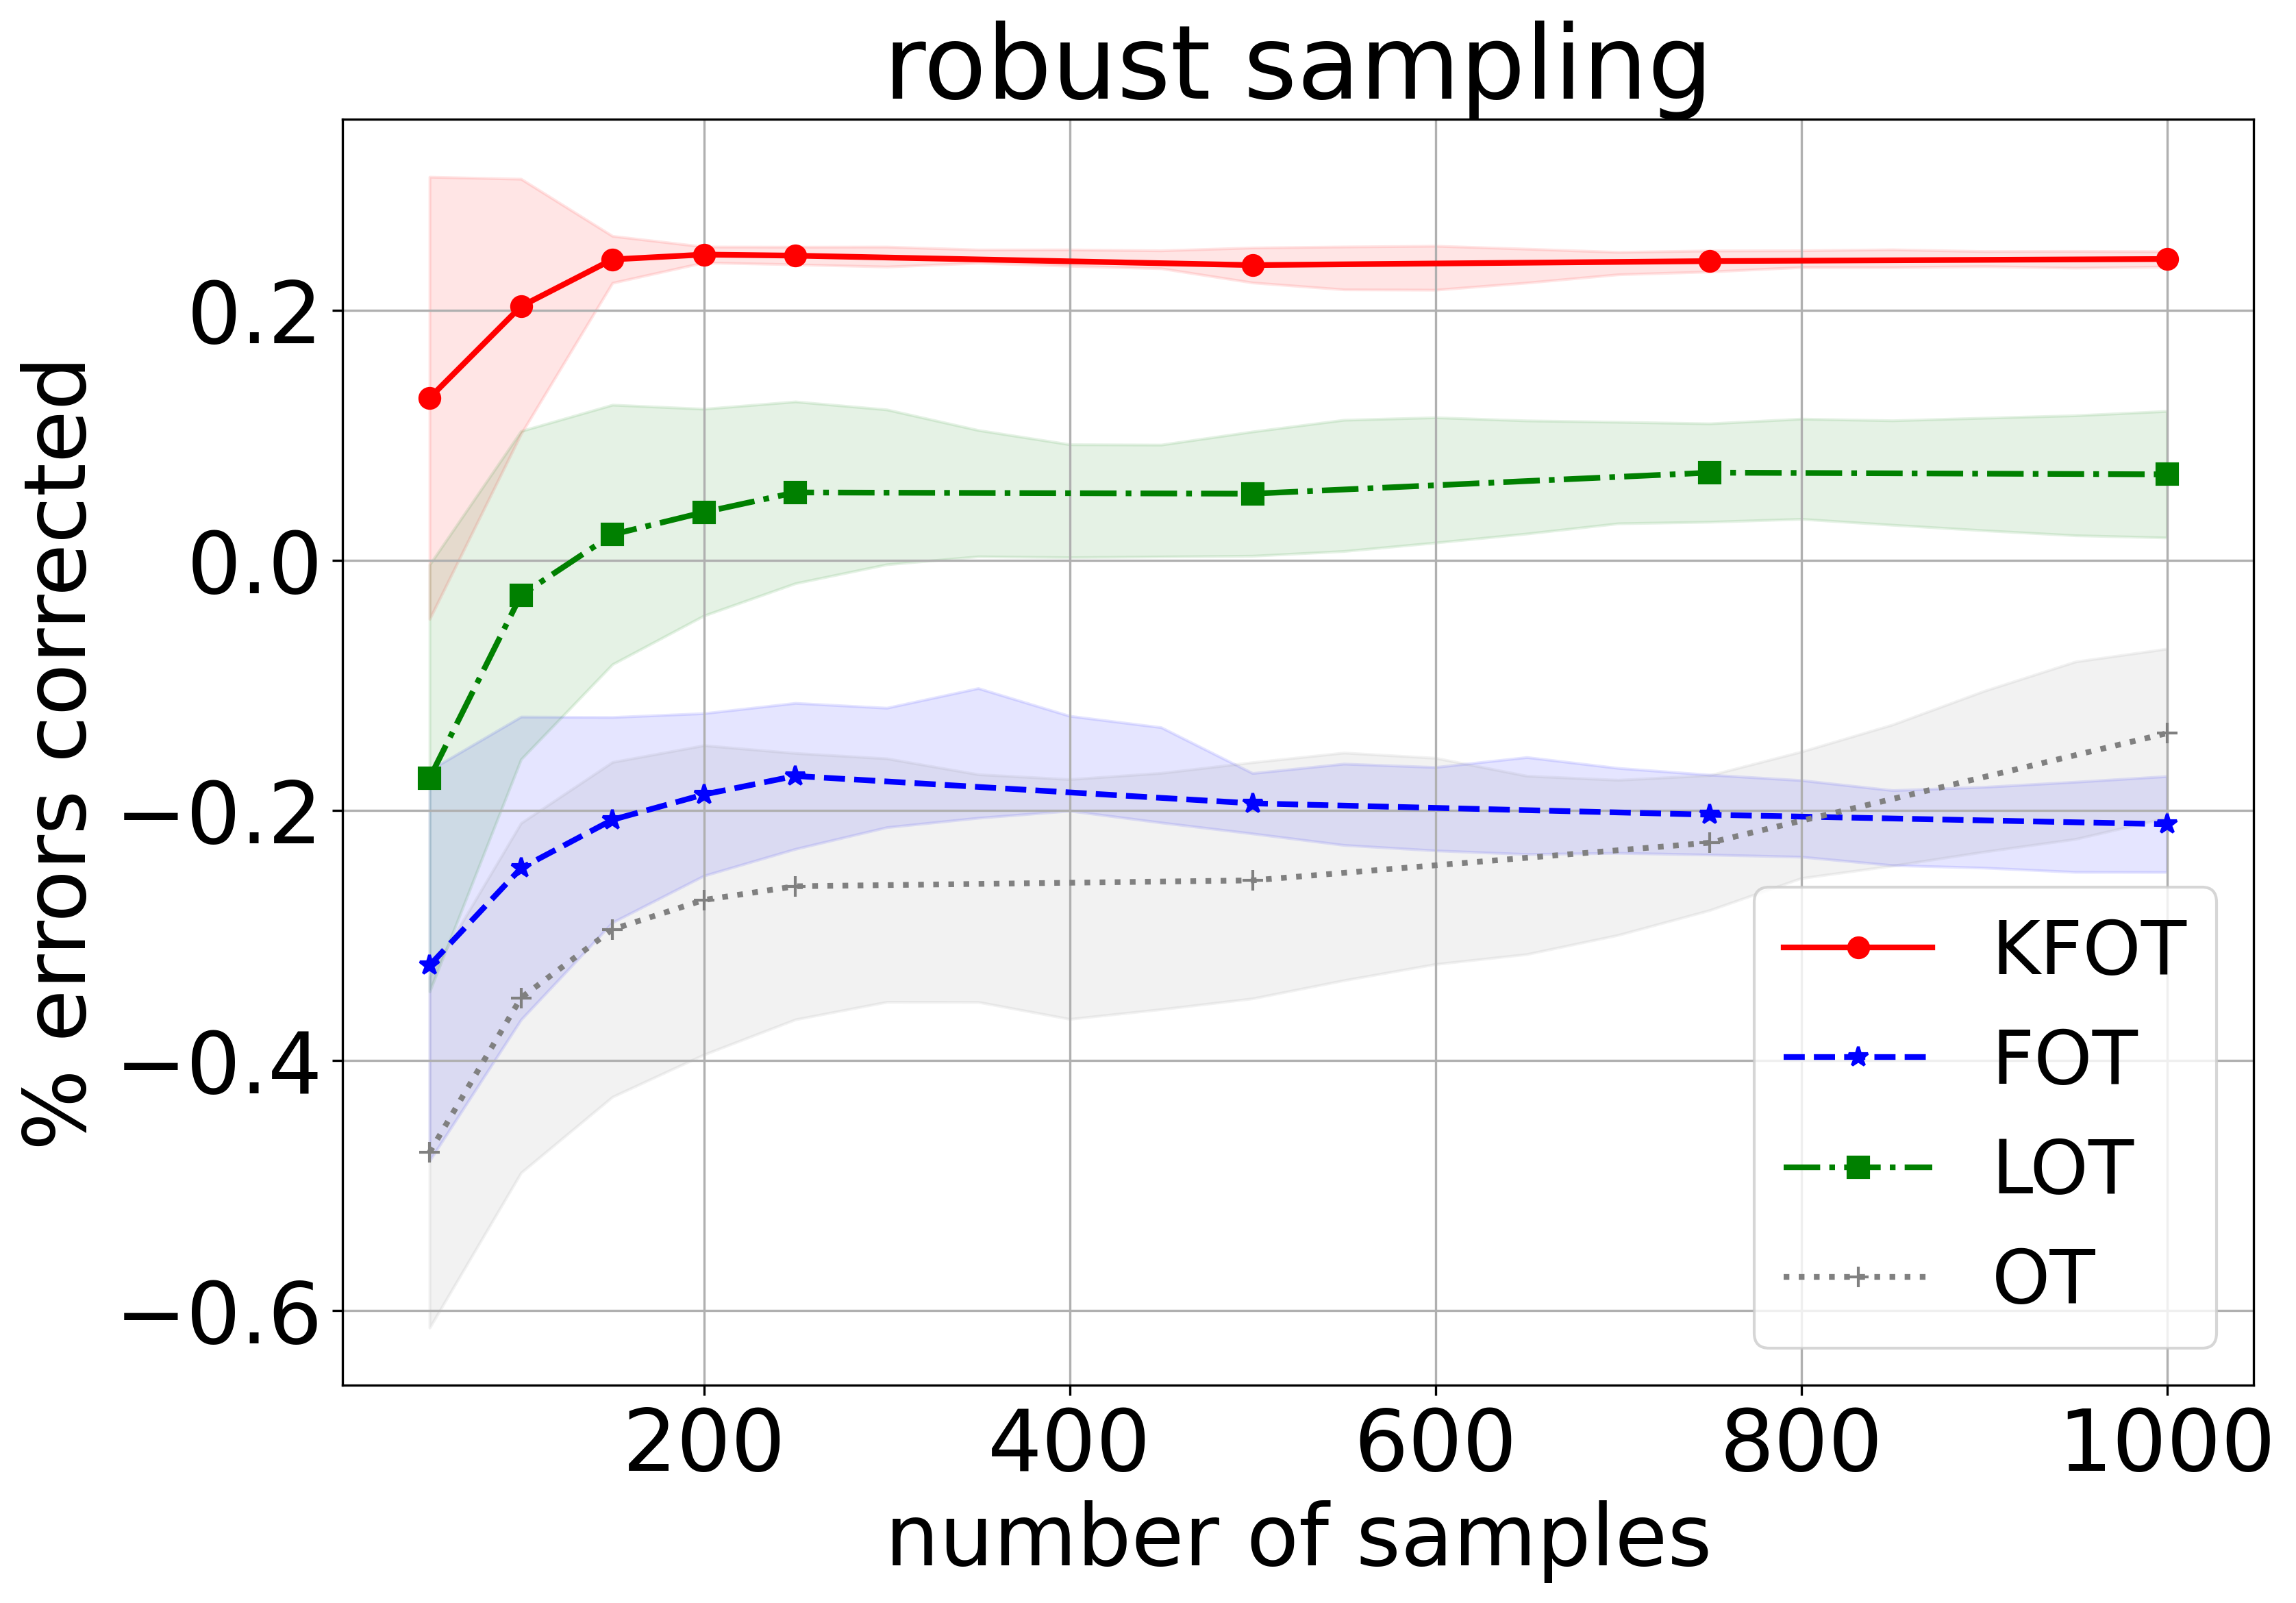

In [3]:
#@title Robust sampling
log_paths = [
    "logs\\robust_sampling\\240416_032636.json",
    "logs\\robust_sampling\\240416_035216.json",
    "logs\\robust_sampling\\240416_042526.json",
    "logs\\robust_sampling\\240416_045143.json",
    "logs\\robust_sampling\\240416_051648.json"
]
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name="robust_sampling",
    records=records,
    y_axis="accuracy"
)
exp_name = "robust_sampling"
include_inds = [0, 1, 2, 3, 4] + [9, 14, 19]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'samples', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        y + moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        alpha=0.1,
        color=colors[i],
    )

plt.title("robust sampling", fontsize=36)
plt.xlabel("number of samples", fontsize=30)
plt.ylabel("% errors corrected", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=26)
plt.grid(True)
plt.show()

In [4]:
#@title DU-MNIST
log_paths = [
    "logs\\du_mnist\\240415_162152.json",
    "logs\\du_mnist\\240415_162338.json",
    "logs\\du_mnist\\240415_162630.json",
    "logs\\du_mnist\\240415_163034.json",
    "logs\\du_mnist\\240415_163330.json",
    "logs\\du_mnist\\240415_163723.json",
    "logs\\du_mnist\\240415_164041.json",
    "logs\\du_mnist\\240415_164152.json",
    "logs\\du_mnist\\240415_164346.json",
    "logs\\du_mnist\\240415_164652.json",
]
exp_name = "du_mnist"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy",
    gt="mnist_test_aug"
)
print(summary["None"])
for model_id, log in summary[exp_name].items():
    print(f'{model_id}: {round(log["summary"]["delta_acc_mean"][0], 4)}{plus_minus}{round(log["summary"]["delta_acc_std"][0], 4)}')

{'mnist_train': [0.995, 0.991, 0.993, 0.993, 0.993, 0.992, 0.99, 0.99, 0.991, 0.993], 'mnist_test': [0.9705, 0.9705, 0.9705, 0.9705, 0.9705, 0.9705, 0.9705, 0.9705, 0.9705, 0.9705], 'usps_train': [0.86, 0.853, 0.841, 0.861, 0.851, 0.86, 0.841, 0.857, 0.841, 0.854], 'usps_test': [0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802, 0.802], 'mnist_test_aug': [0.551, 0.551, 0.551, 0.551, 0.551, 0.551, 0.551, 0.551, 0.551, 0.551]}
KeypointFOT: 0.2717±0.0423
FOT: 0.0697±0.0052
LOT: 0.1013±0.026
OT: -0.0016±0.0321


In [10]:
#@title USPS-MNIST
log_paths = [
    "logs\\usps_to_mnist\\240413_110605.json",
    "logs\\usps_to_mnist\\240413_110825.json",
    "logs\\usps_to_mnist\\240413_111147.json",
    "logs\\usps_to_mnist\\240413_111327.json",
    "logs\\usps_to_mnist\\240413_111538.json",
    "logs\\usps_to_mnist\\240413_111743.json",
    "logs\\usps_to_mnist\\240413_112216.json",
    "logs\\usps_to_mnist\\240413_112436.json",
    "logs\\usps_to_mnist\\240413_112631.json",
    "logs\\usps_to_mnist\\240413_112850.json",
]
exp_name = "usps_to_mnist"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy",
)
for model_id, log in summary[exp_name].items():
    print(f'{model_id}: {round(log["summary"]["delta_acc_mean"][0], 4)}{plus_minus}{round(log["summary"]["delta_acc_std"][0], 4)}')

KeypointFOT: 0.1611±0.0448
FOT: -0.2288±0.0358
LOT: 0.0816±0.0565
OT: -0.1164±0.0465


In [28]:
#@title USPS-MNIST
log_paths = [
    "logs\\usps_to_mnist\\240416_025801.json",
    "logs\\usps_to_mnist\\240416_030014.json",
    "logs\\usps_to_mnist\\240416_030308.json",
    "logs\\usps_to_mnist\\240416_030430.json",
    "logs\\usps_to_mnist\\240416_030620.json",
    "logs\\usps_to_mnist\\240416_031044.json",
    "logs\\usps_to_mnist\\240416_031436.json",
    "logs\\usps_to_mnist\\240416_031917.json",
    "logs\\usps_to_mnist\\240416_032033.json",
    "logs\\usps_to_mnist\\240416_032516.json",
]
exp_name = "usps_to_mnist"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy",
)
for model_id, log in summary[exp_name].items():
    print(f'{model_id}: {round(log["summary"]["delta_acc_mean"][0], 4)}{plus_minus}{round(log["summary"]["delta_acc_std"][0], 4)}')

KeypointFOT: 0.2422±0.0055
FOT: -0.2288±0.0358
LOT: 0.0816±0.0565
OT: -0.1164±0.0465


# Robustness to Pertubations

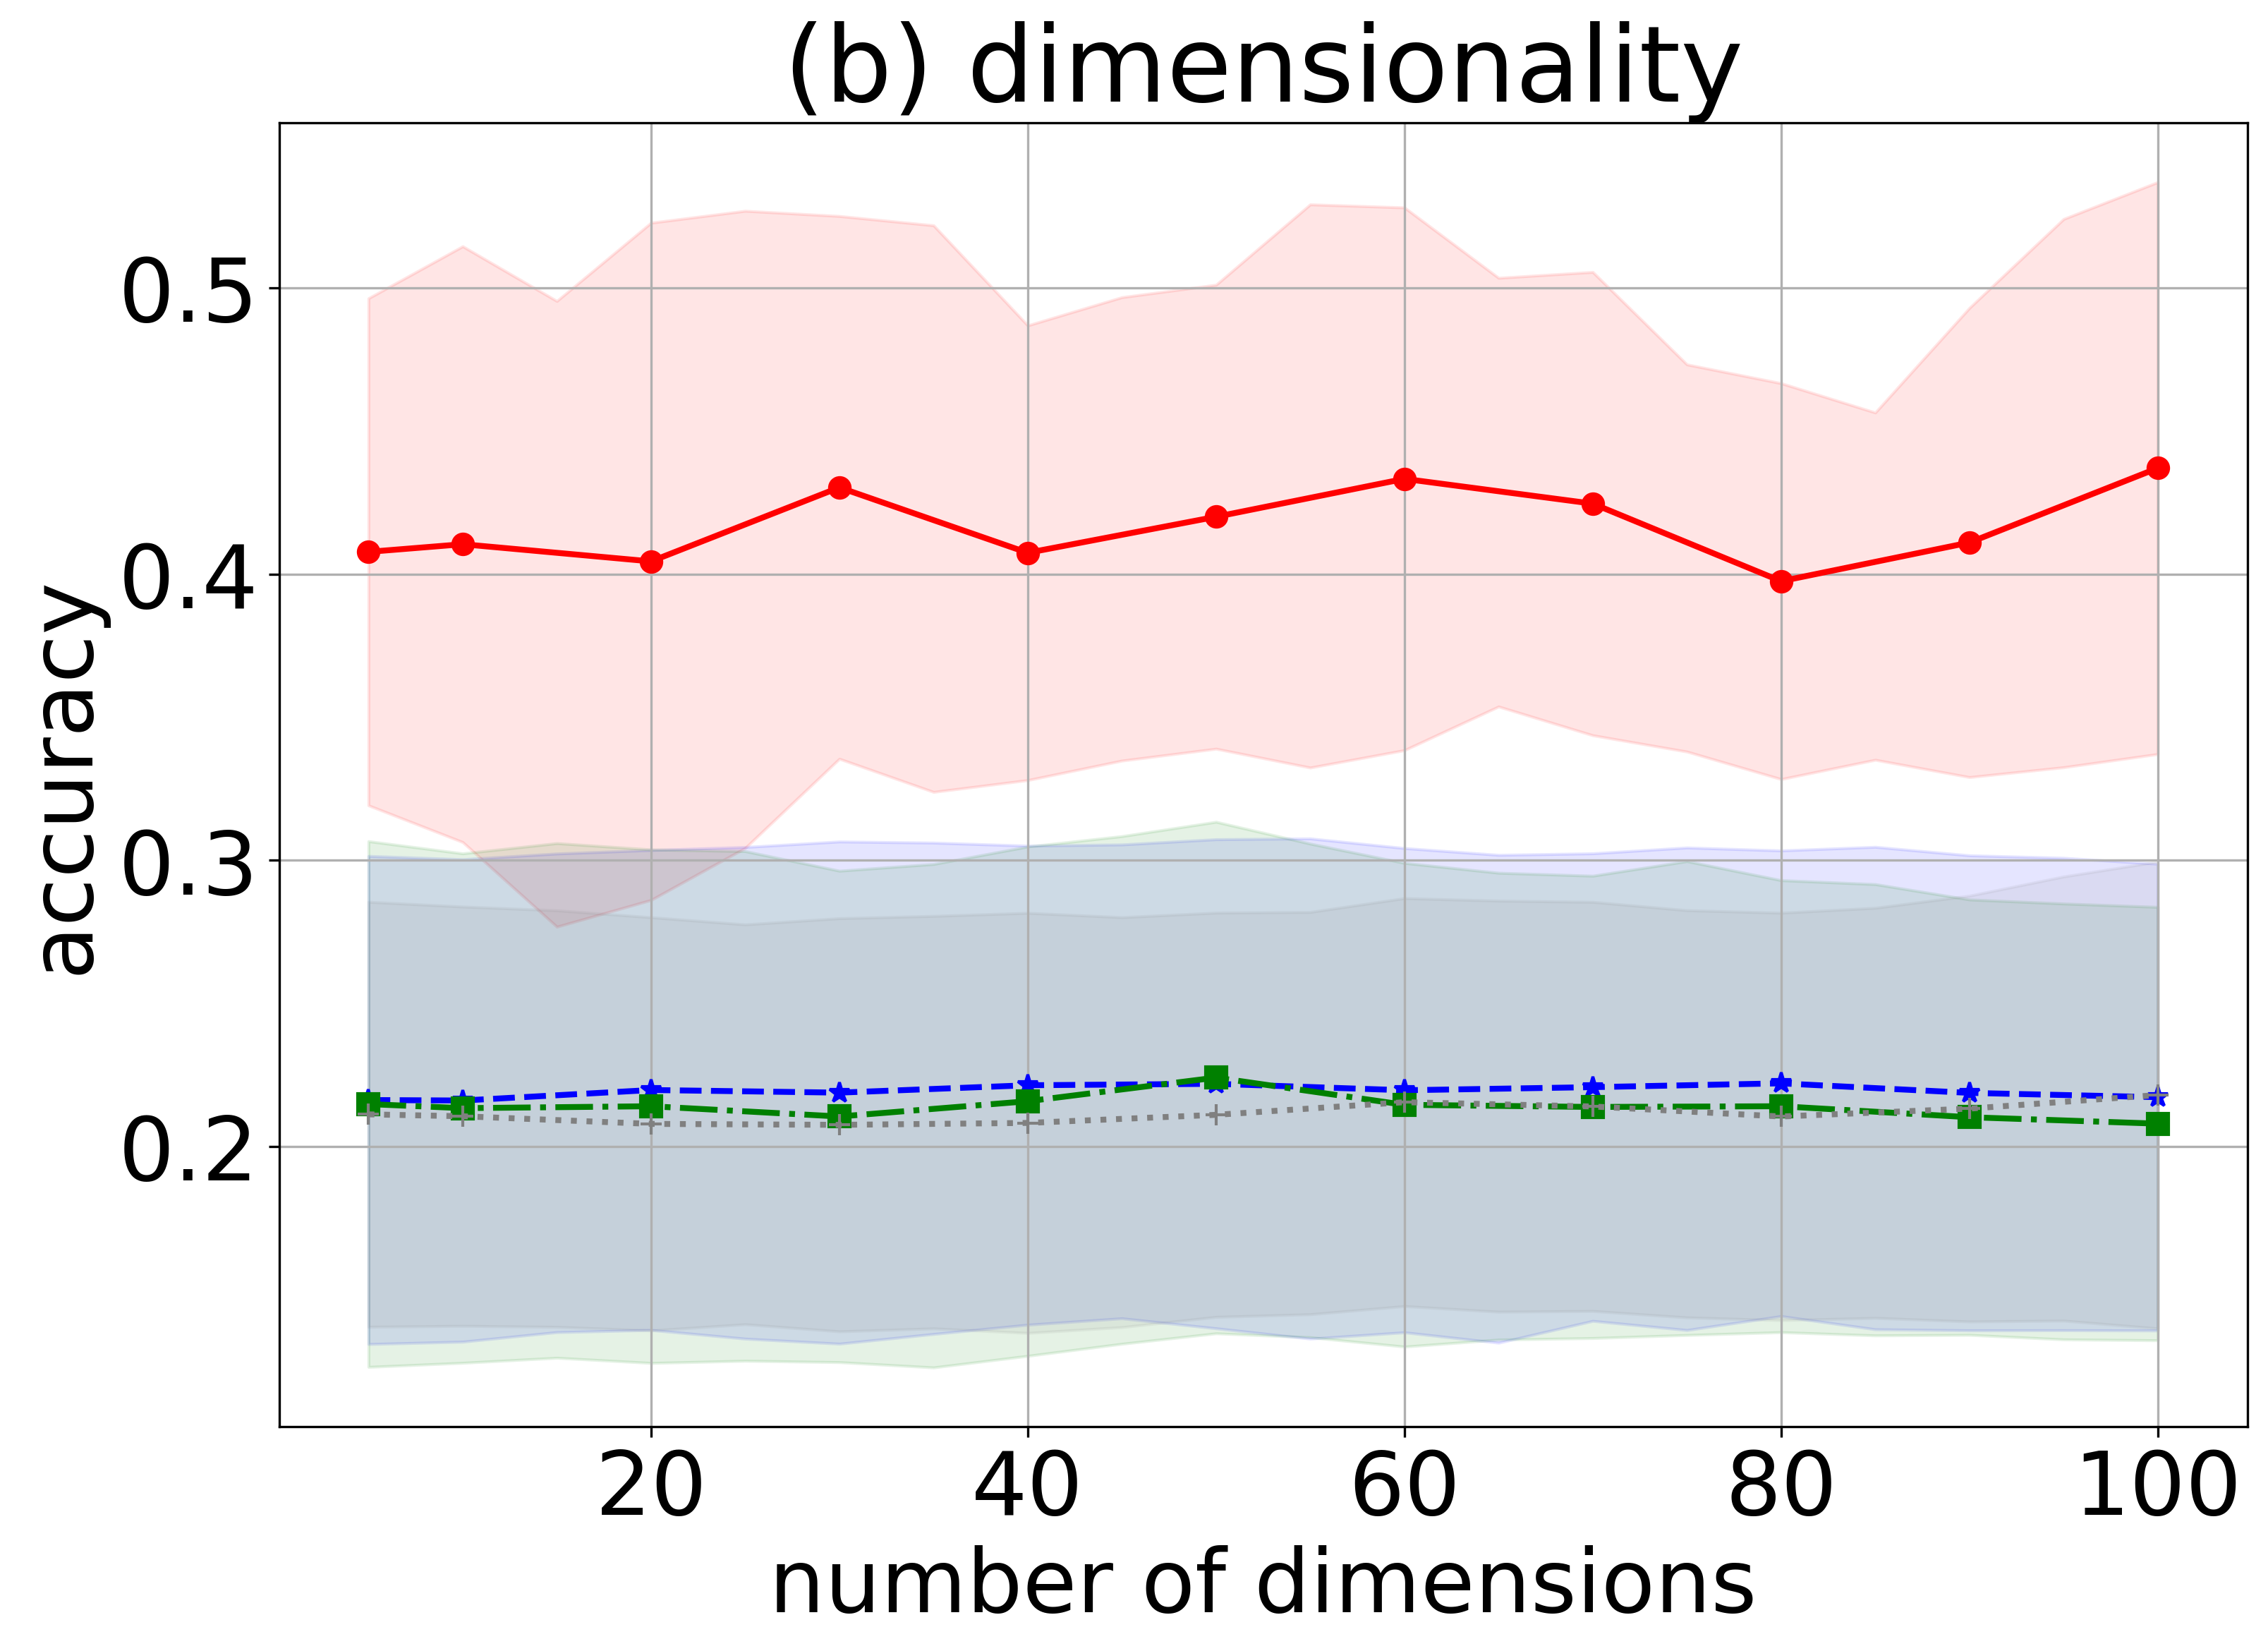

In [4]:
#@title Dimensionality
log_paths = [
    "logs\\dimensionality\\240413_112725.json",
    "logs\\dimensionality\\240413_115625.json",
    "logs\\dimensionality\\240413_121823.json",
    "logs\\dimensionality\\240413_124321.json",
    "logs\\dimensionality\\240413_130317.json",
    "logs\\dimensionality\\240413_132745.json",
    "logs\\dimensionality\\240413_135621.json",
    "logs\\dimensionality\\240413_142209.json",
    "logs\\dimensionality\\240413_144913.json",
    "logs\\dimensionality\\240413_151525.json"
]
exp_name = "dimensionality"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
include_inds = [i for i in range(len(summary[exp_name]["KeypointFOT"]["summary"]["delta_acc_mean"])) if i == 0 or i % 2 != 0]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'dimension', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        y + 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        alpha=0.1,
        color=colors[i],
    )

plt.title(f"(b) {exp_name}", fontsize=36)
plt.xlabel("number of dimensions", fontsize=30)
plt.ylabel("accuracy", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend(fontsize=16)
plt.grid(True)
plt.show()

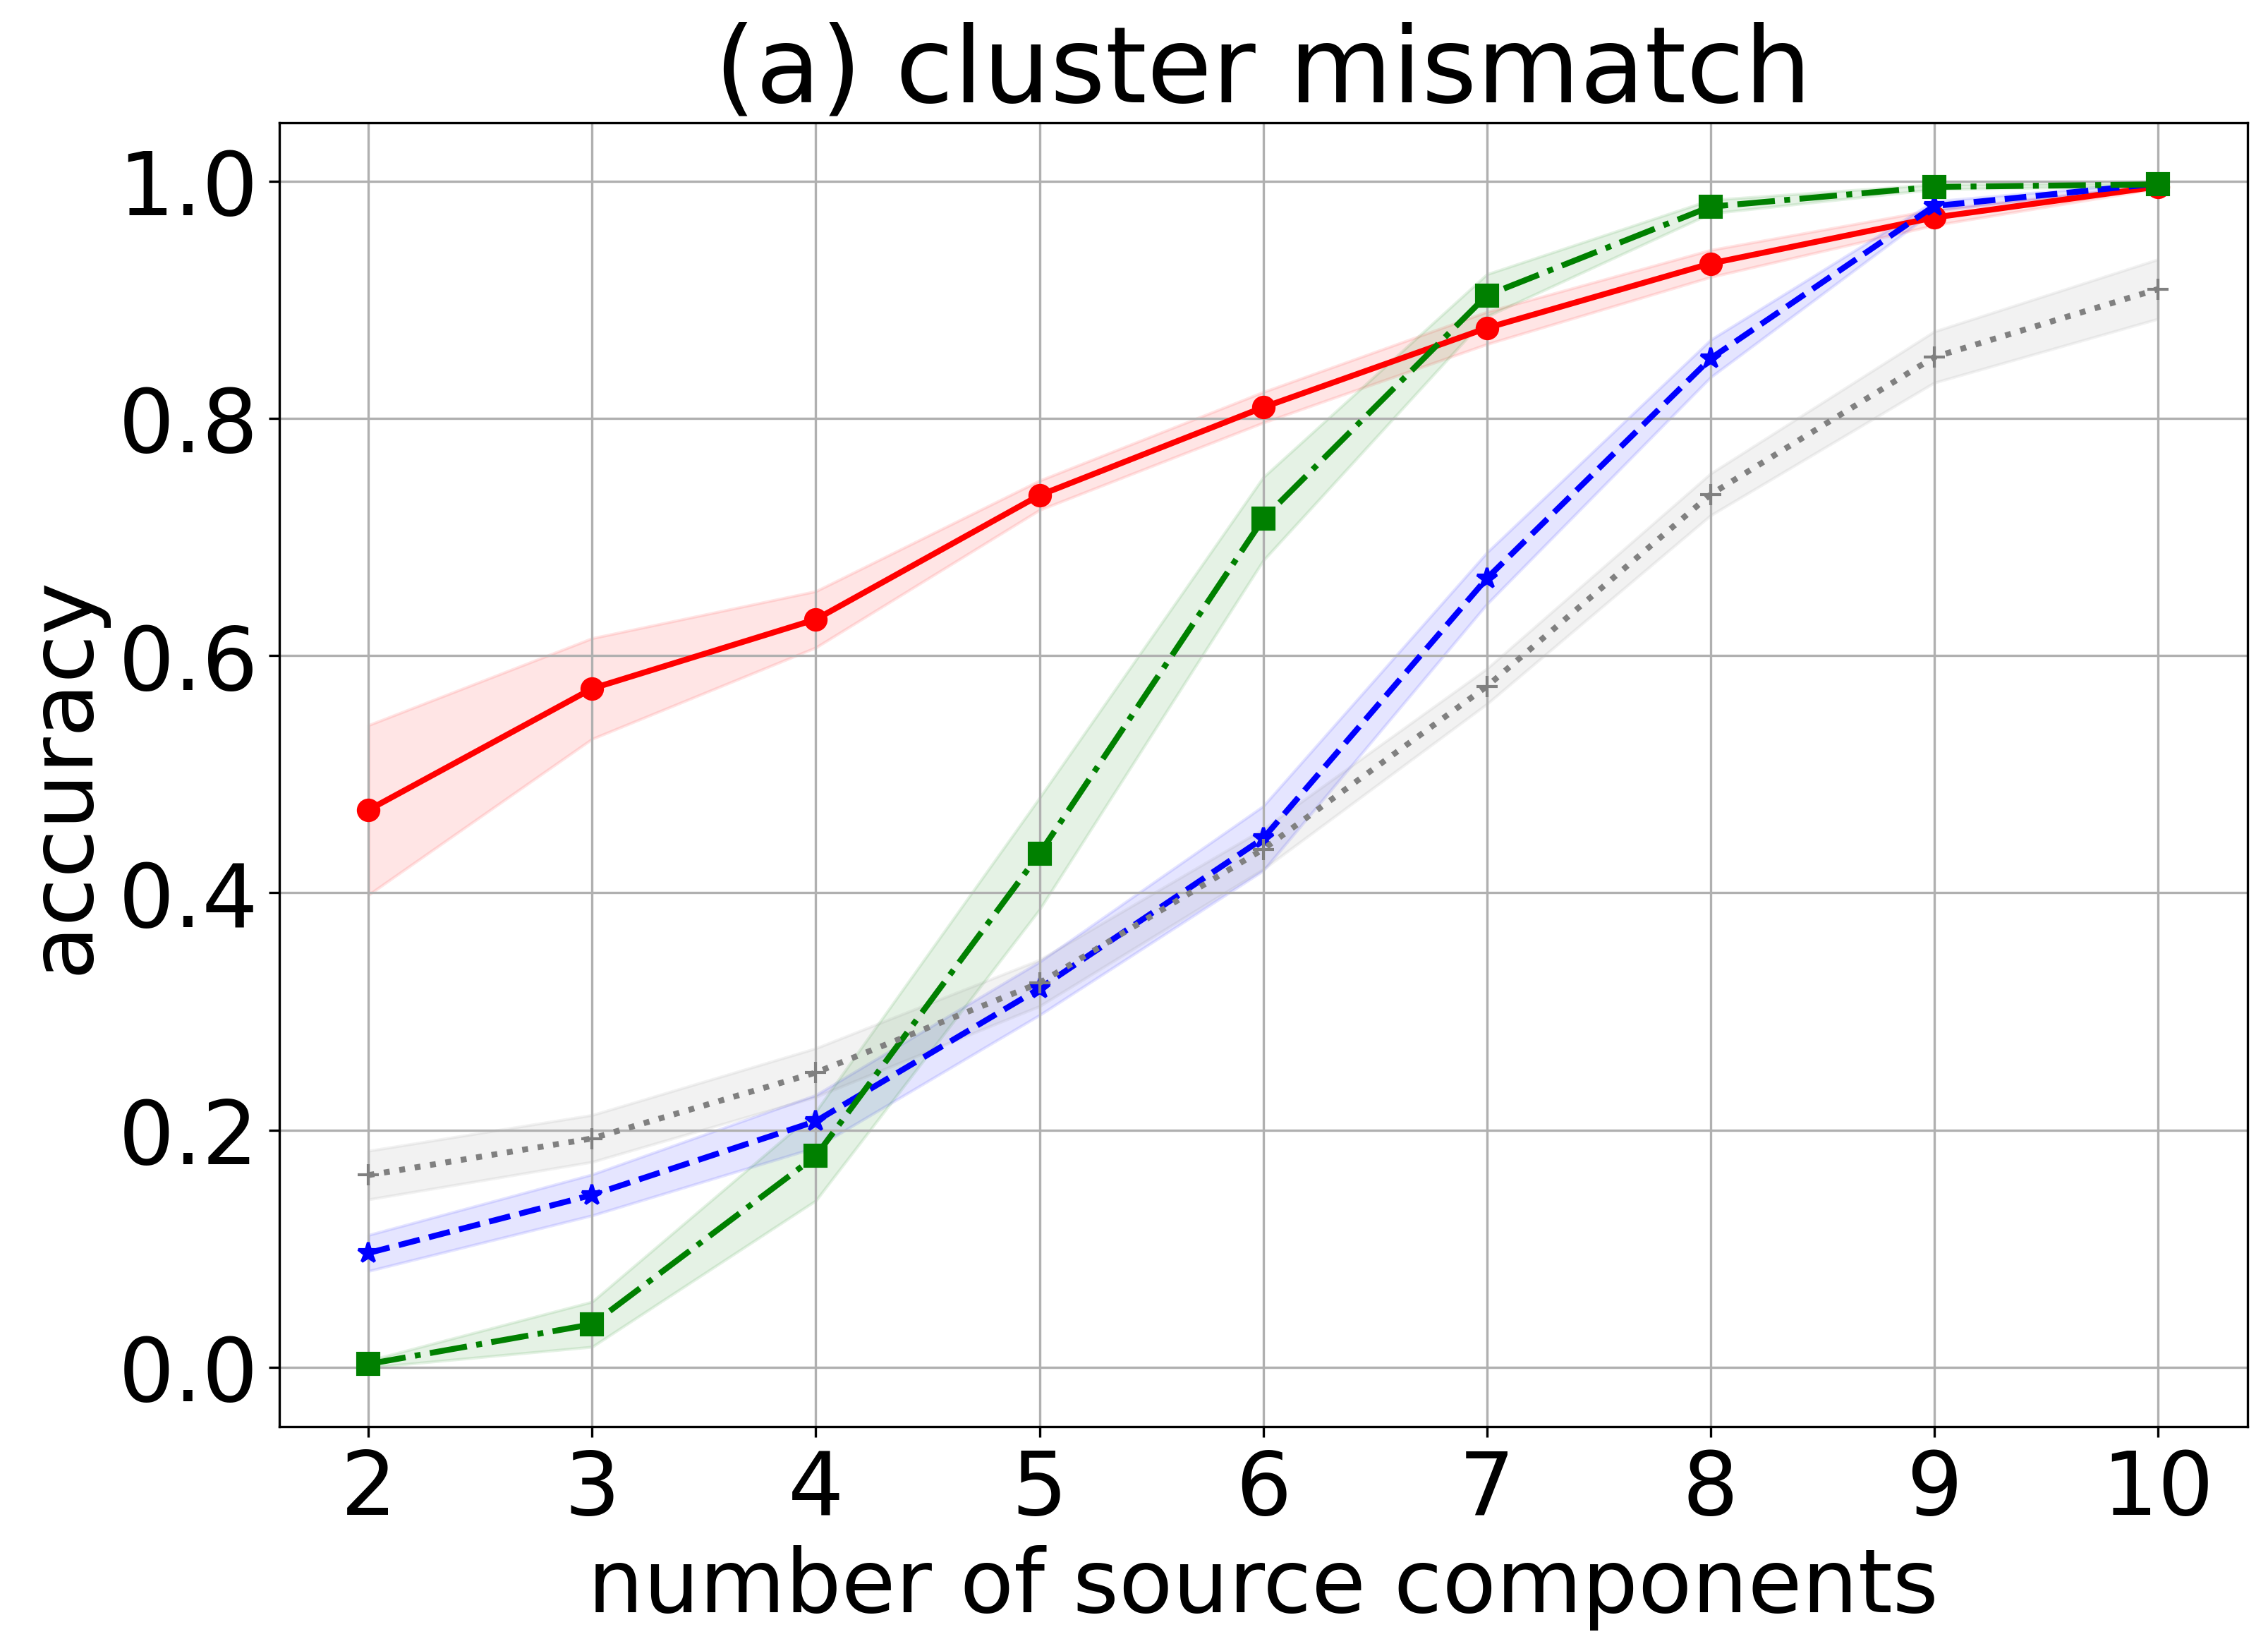

In [9]:
#@title Cluster mismatch
log_paths = [
    "logs\\cluster_mismatch\\240413_164022.json",
    "logs\\cluster_mismatch\\240413_164345.json",
    "logs\\cluster_mismatch\\240413_164716.json",
    "logs\\cluster_mismatch\\240413_165027.json",
    "logs\\cluster_mismatch\\240413_165351.json",
    "logs\\cluster_mismatch\\240413_165717.json",
    "logs\\cluster_mismatch\\240413_170018.json",
    "logs\\cluster_mismatch\\240413_170329.json",
    "logs\\cluster_mismatch\\240413_170626.json",
    "logs\\cluster_mismatch\\240413_170938.json"
]
exp_name = "cluster_mismatch"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
include_inds = [i for i in range(len(summary[exp_name]["KeypointFOT"]["summary"]["delta_acc_mean"]))]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'cluster', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        y + 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        alpha=0.1,
        color=colors[i],
    )

plt.title("(a) cluster mismatch", fontsize=36)
plt.xlabel("number of source components", fontsize=30)
plt.ylabel("accuracy", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend(fontsize=16, loc="lower right")
plt.grid(True)
plt.show()

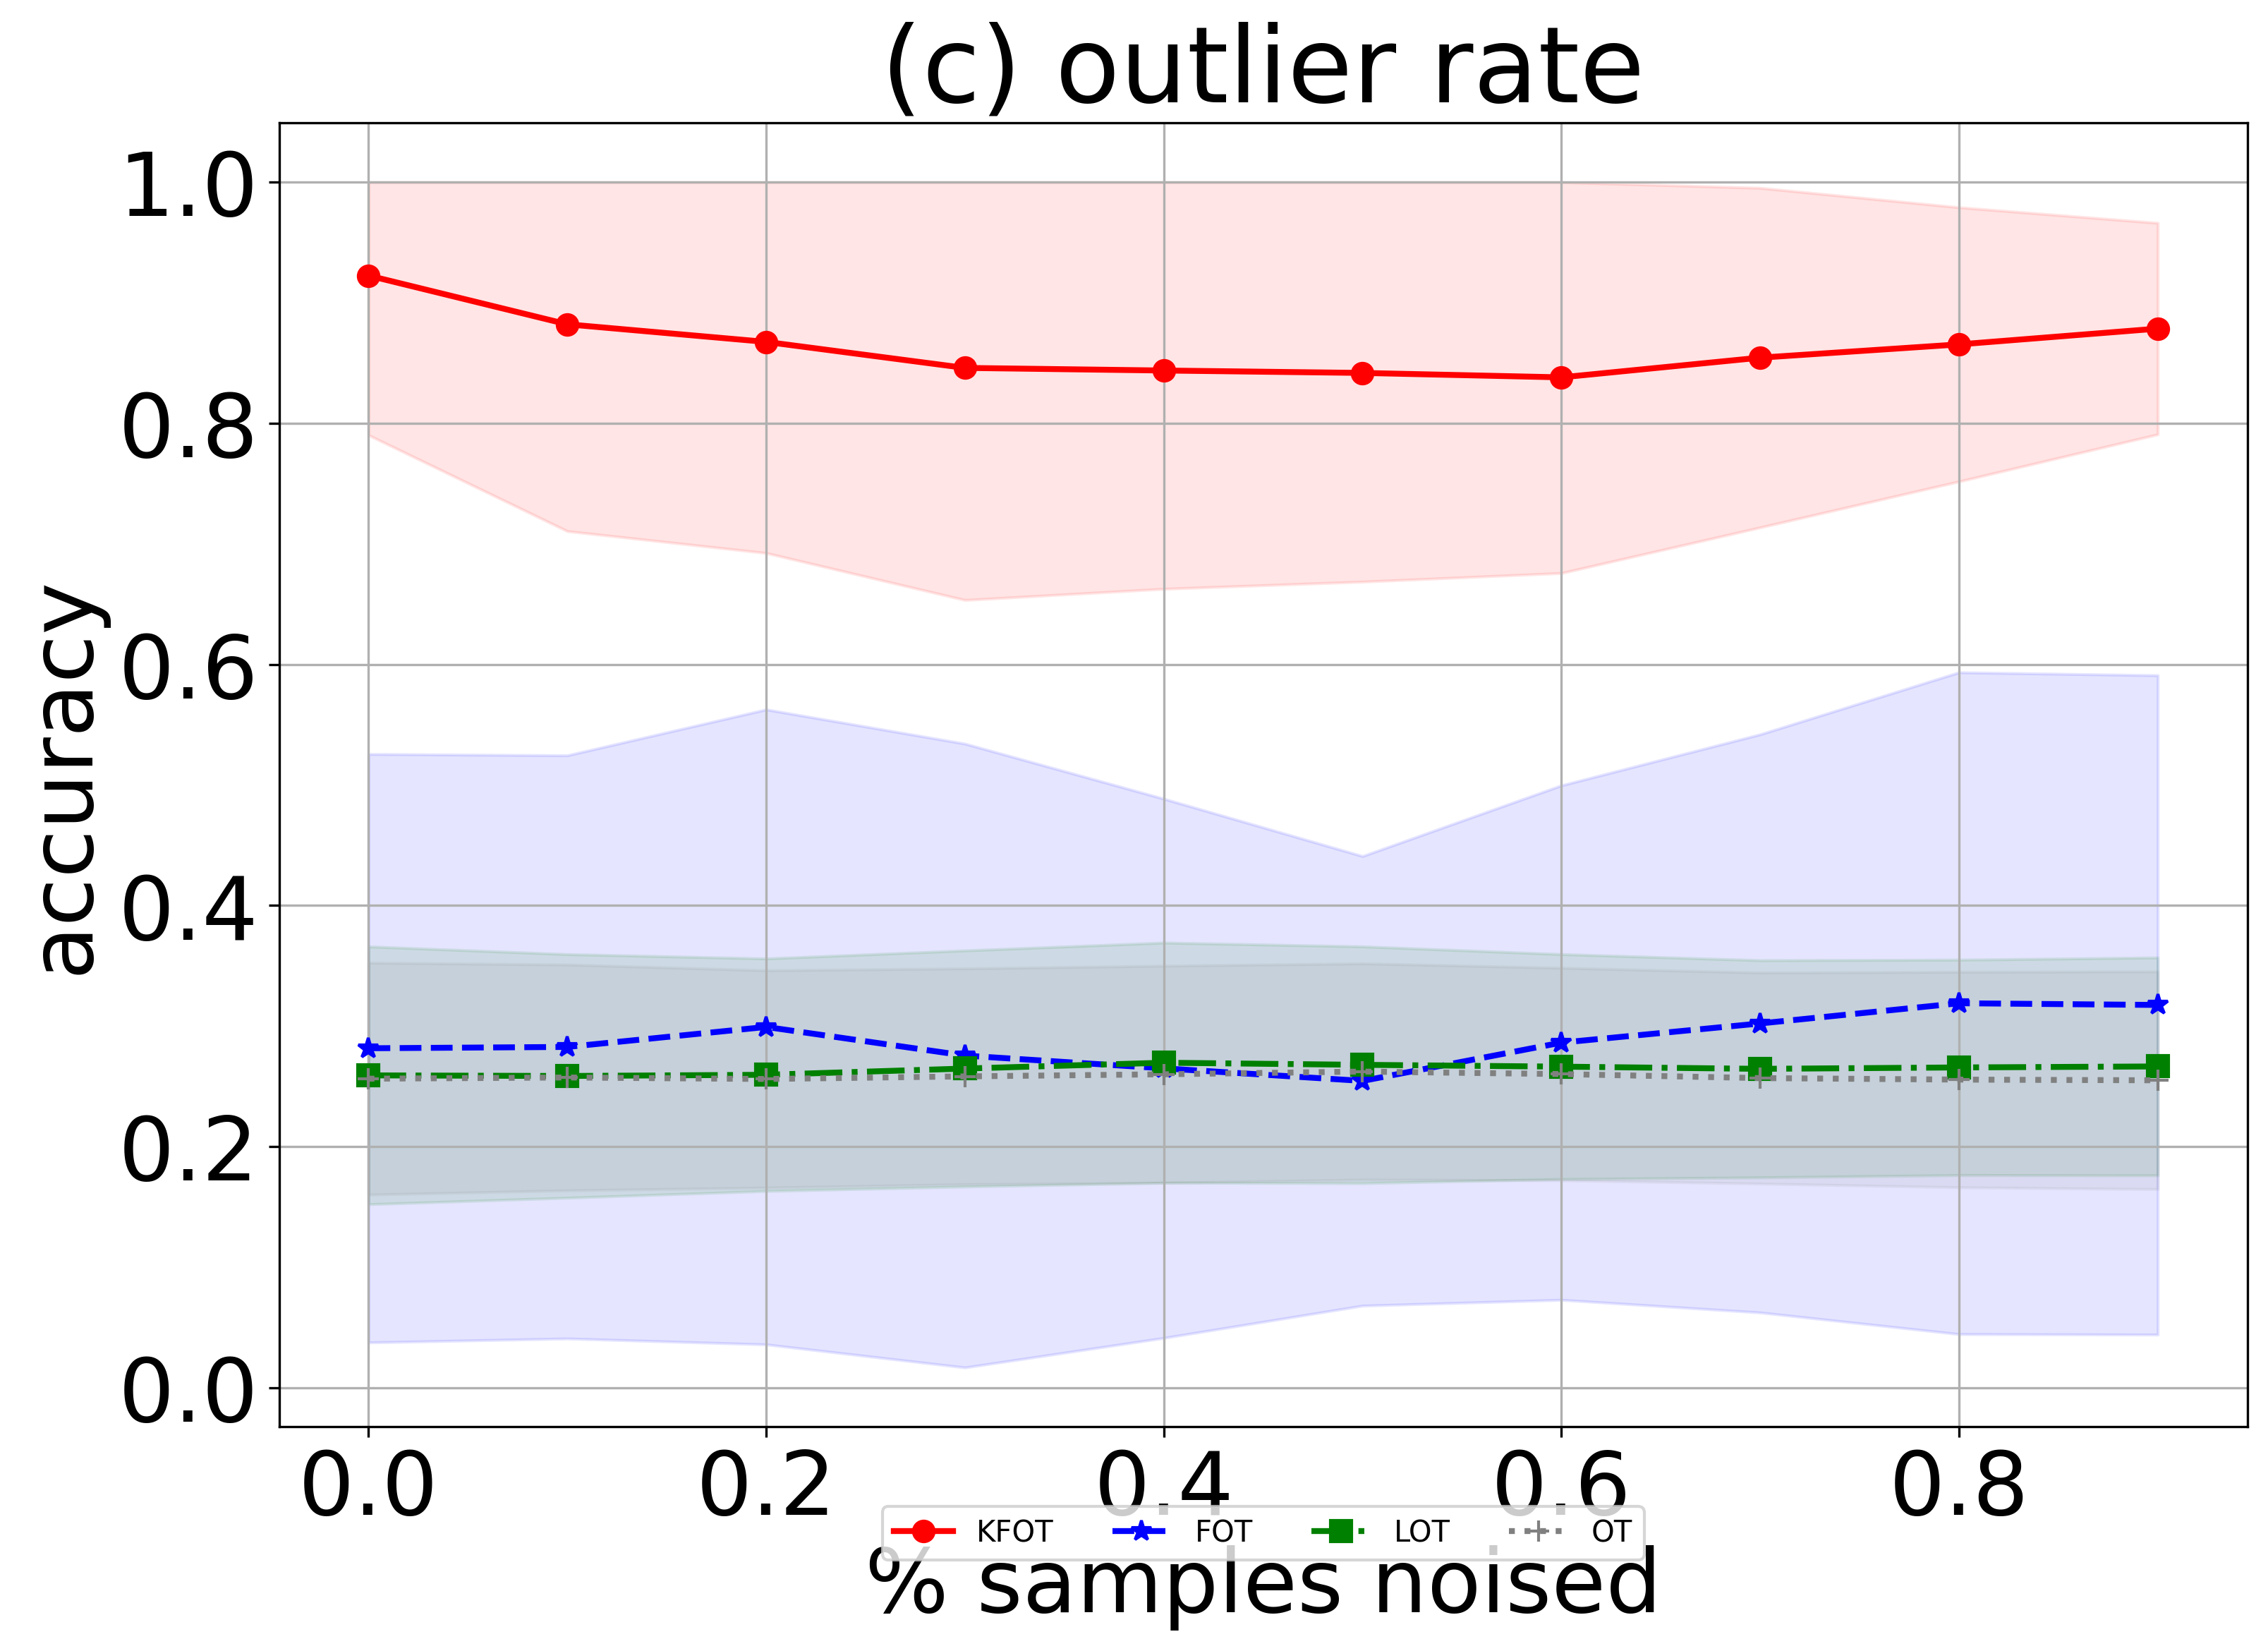

In [7]:
#@title Outlier rate
log_paths = [
    "logs\\outlier_rate\\240413_153946.json",
    "logs\\outlier_rate\\240413_154922.json",
    "logs\\outlier_rate\\240413_155343.json",
    "logs\\outlier_rate\\240413_160302.json",
    "logs\\outlier_rate\\240413_160831.json",
    "logs\\outlier_rate\\240413_161143.json",
    "logs\\outlier_rate\\240413_162135.json",
    "logs\\outlier_rate\\240413_162504.json",
    "logs\\outlier_rate\\240413_162820.json",
    "logs\\outlier_rate\\240413_163113.json"
]
exp_name = "outlier_rate"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
include_inds = [i for i in range(len(summary[exp_name]["KeypointFOT"]["summary"]["delta_acc_mean"]))]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'ratio', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        np.clip(y + 1 * moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window), a_min=None, a_max=1.0),
        alpha=0.1,
        color=colors[i],
    )

plt.title("(c) outlier rate", fontsize=36)
plt.xlabel("% samples noised", fontsize=30)
plt.ylabel("accuracy", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False, ncol=4)
#plt.legend(fontsize=16, loc="lower right")
plt.grid(True)
plt.show()

# Ablation Study

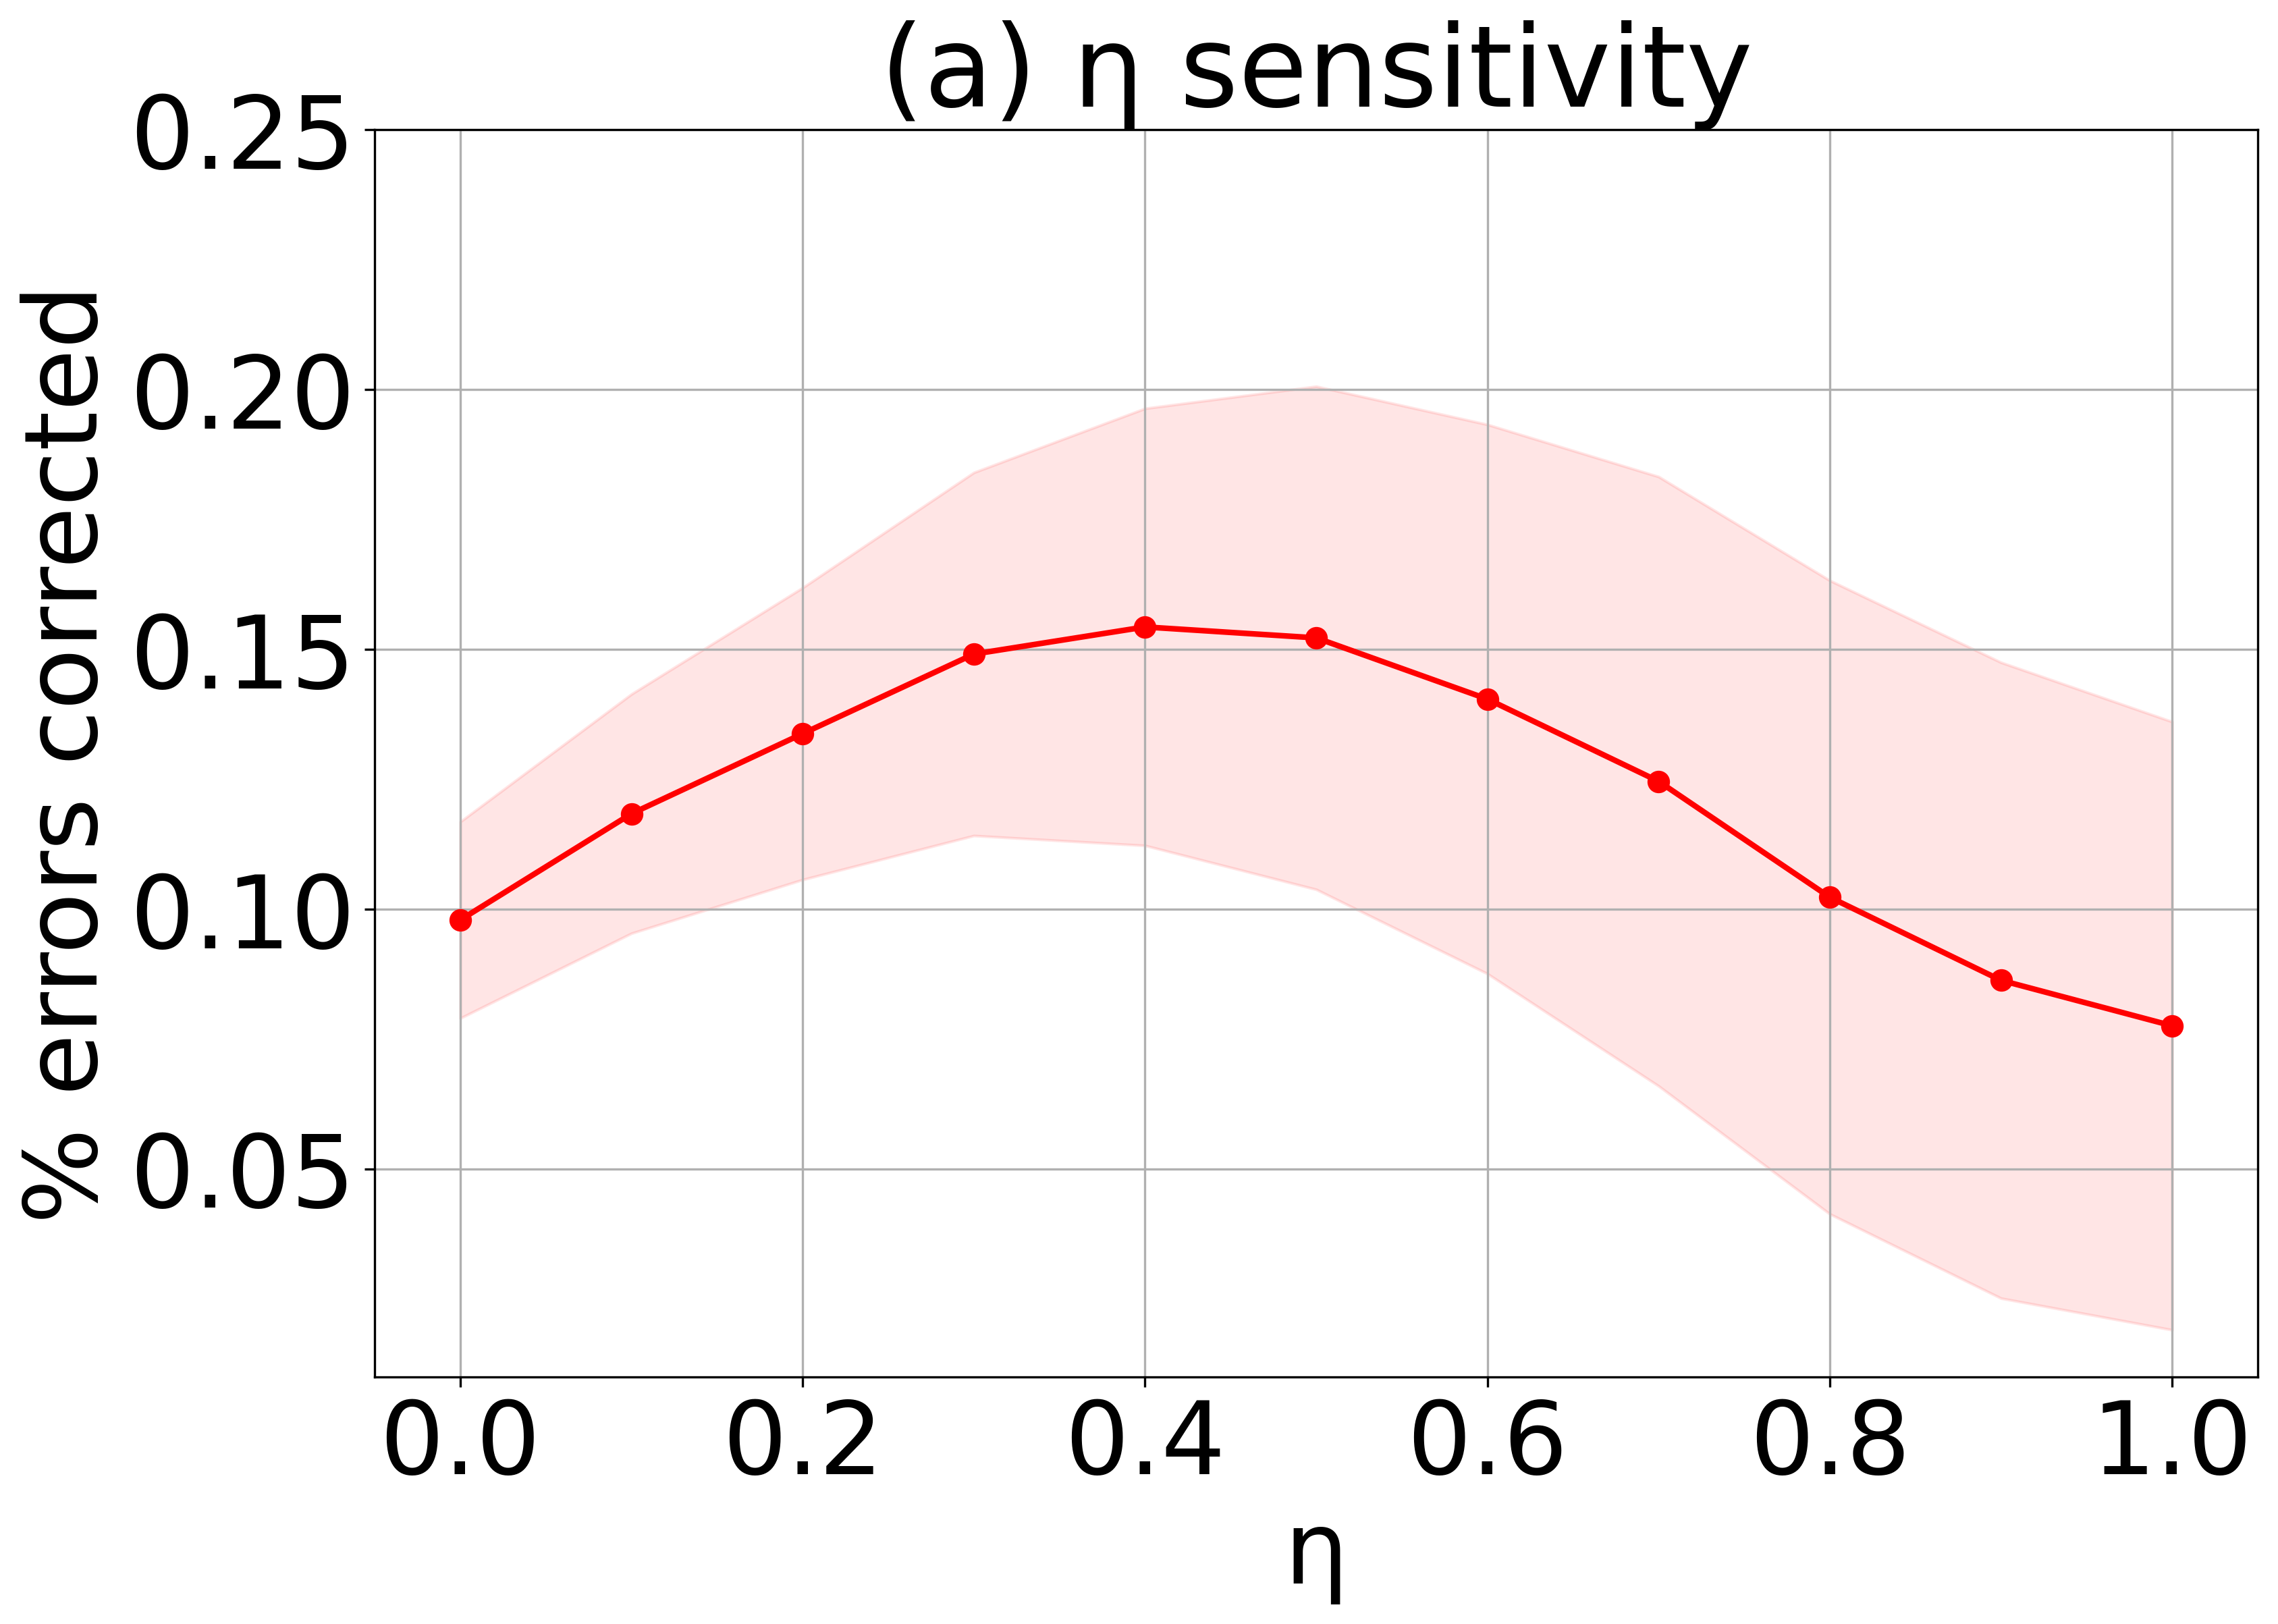

In [3]:
#@title Alpha sensitive
log_paths = [
    "logs\\mix_sensitive\\240414_072100.json",
    "logs\\mix_sensitive\\240414_072533.json",
    "logs\\mix_sensitive\\240414_072903.json",
    "logs\\mix_sensitive\\240414_073345.json",
    "logs\\mix_sensitive\\240414_073831.json",
    "logs\\mix_sensitive\\240414_074301.json",
    "logs\\mix_sensitive\\240414_074722.json",
    "logs\\mix_sensitive\\240414_075242.json",
    "logs\\mix_sensitive\\240414_075716.json",
    "logs\\mix_sensitive\\240414_080108.json"
]
exp_name = "mix_sensitive"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'guide_mix', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0]), 
        np.array(y), 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        y + moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        alpha=0.1,
        color=colors[i],
    )

plt.title("(a) " + u"\u03B7" + " sensitivity", fontsize=40)
plt.xlabel(u"\u03B7", fontsize=36)
plt.ylabel("% errors corrected", fontsize=36)
plt.xticks(fontsize=36)
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25] , fontsize=36)
#plt.legend()
plt.grid(True)
plt.show()

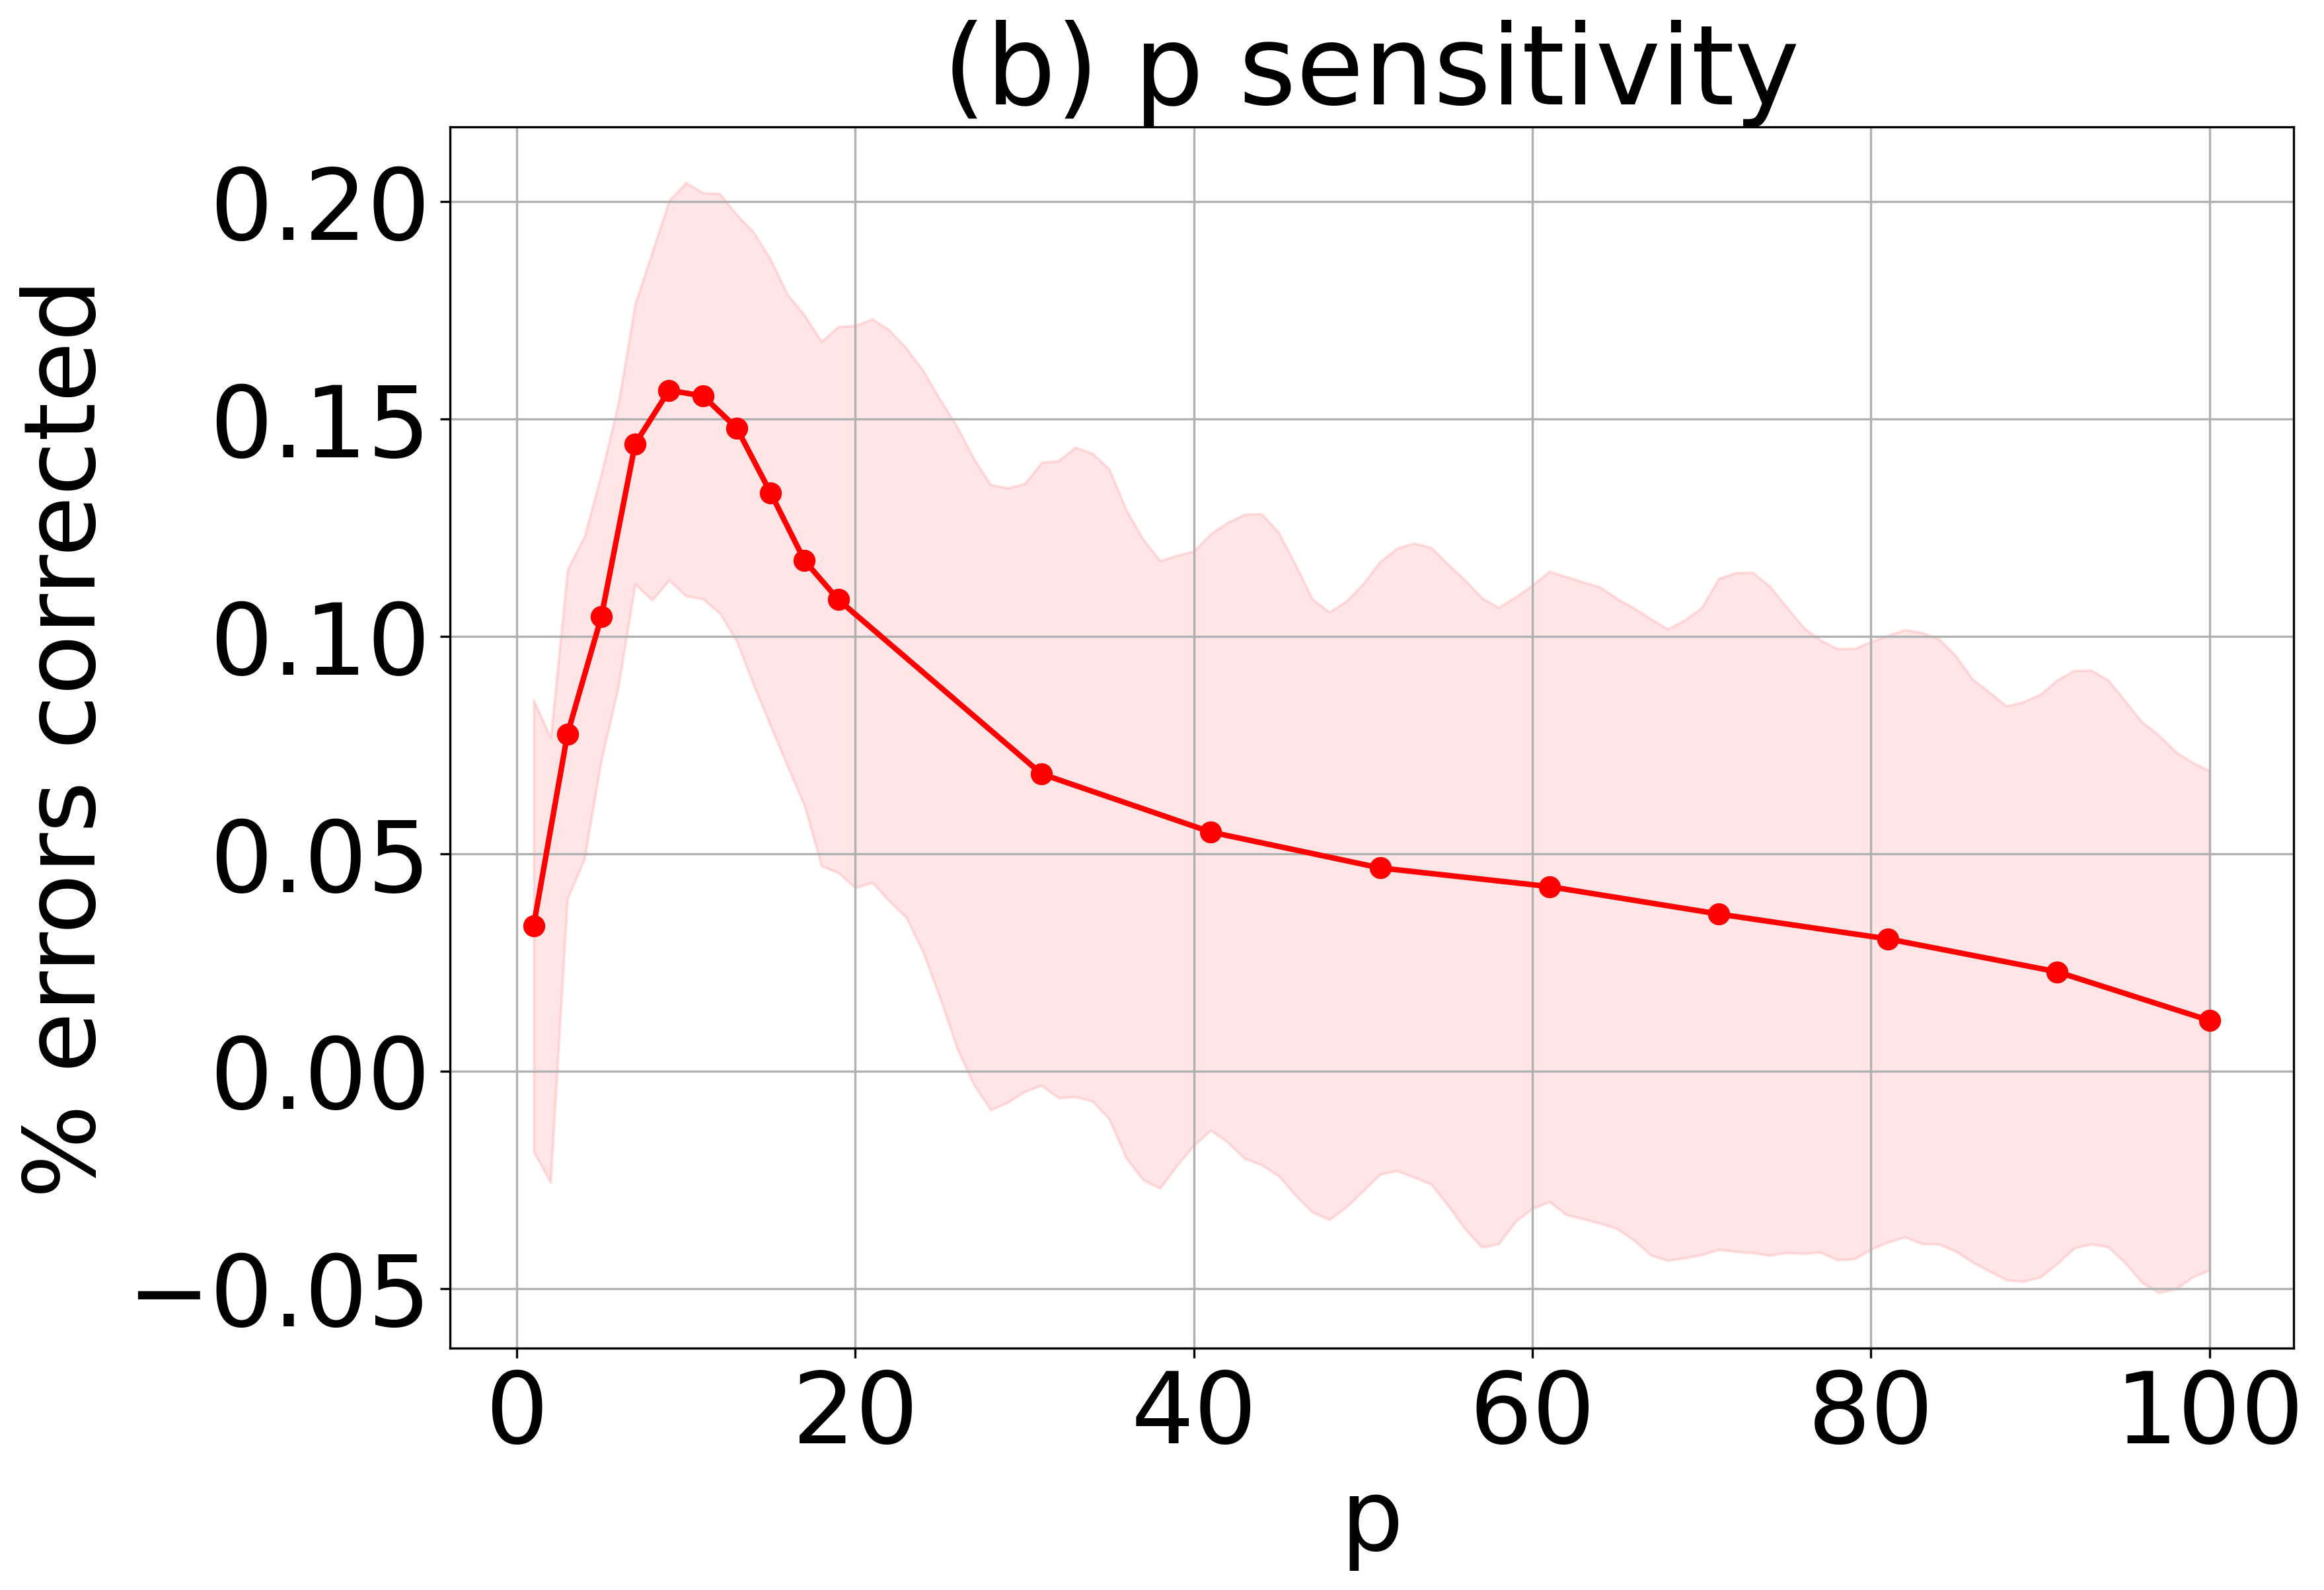

In [4]:
#@title Keypoint sensitive
log_paths = [
    "logs\\keypoint_sensitive\\240415_163200.json",
    "logs\\keypoint_sensitive\\240415_180007.json",
    "logs\\keypoint_sensitive\\240415_193026.json",
    "logs\\keypoint_sensitive\\240415_204507.json",
    "logs\\keypoint_sensitive\\240415_221050.json",
    "logs\\keypoint_sensitive\\240416_000255.json",
    "logs\\keypoint_sensitive\\240416_011833.json",
    "logs\\keypoint_sensitive\\240416_032043.json",
    "logs\\keypoint_sensitive\\240416_051052.json",
    "logs\\keypoint_sensitive\\240416_065015.json"
]
exp_name = "keypoint_sensitive"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
include_inds = [i * 2 for i in range(10)] + [i * 10 for i in range(3, 10)] + [99]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 3
x_axis, y_axis = 'keypoints', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        record_[x_axis][0],
        y - moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        y + moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window),
        alpha=0.1,
        color=colors[i],
    )

plt.title("(b) " + "p sensitivity", fontsize=40)
plt.xlabel("p", fontsize=36)
plt.ylabel("% errors corrected", fontsize=36)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
#plt.legend()
plt.grid(True)
plt.show()

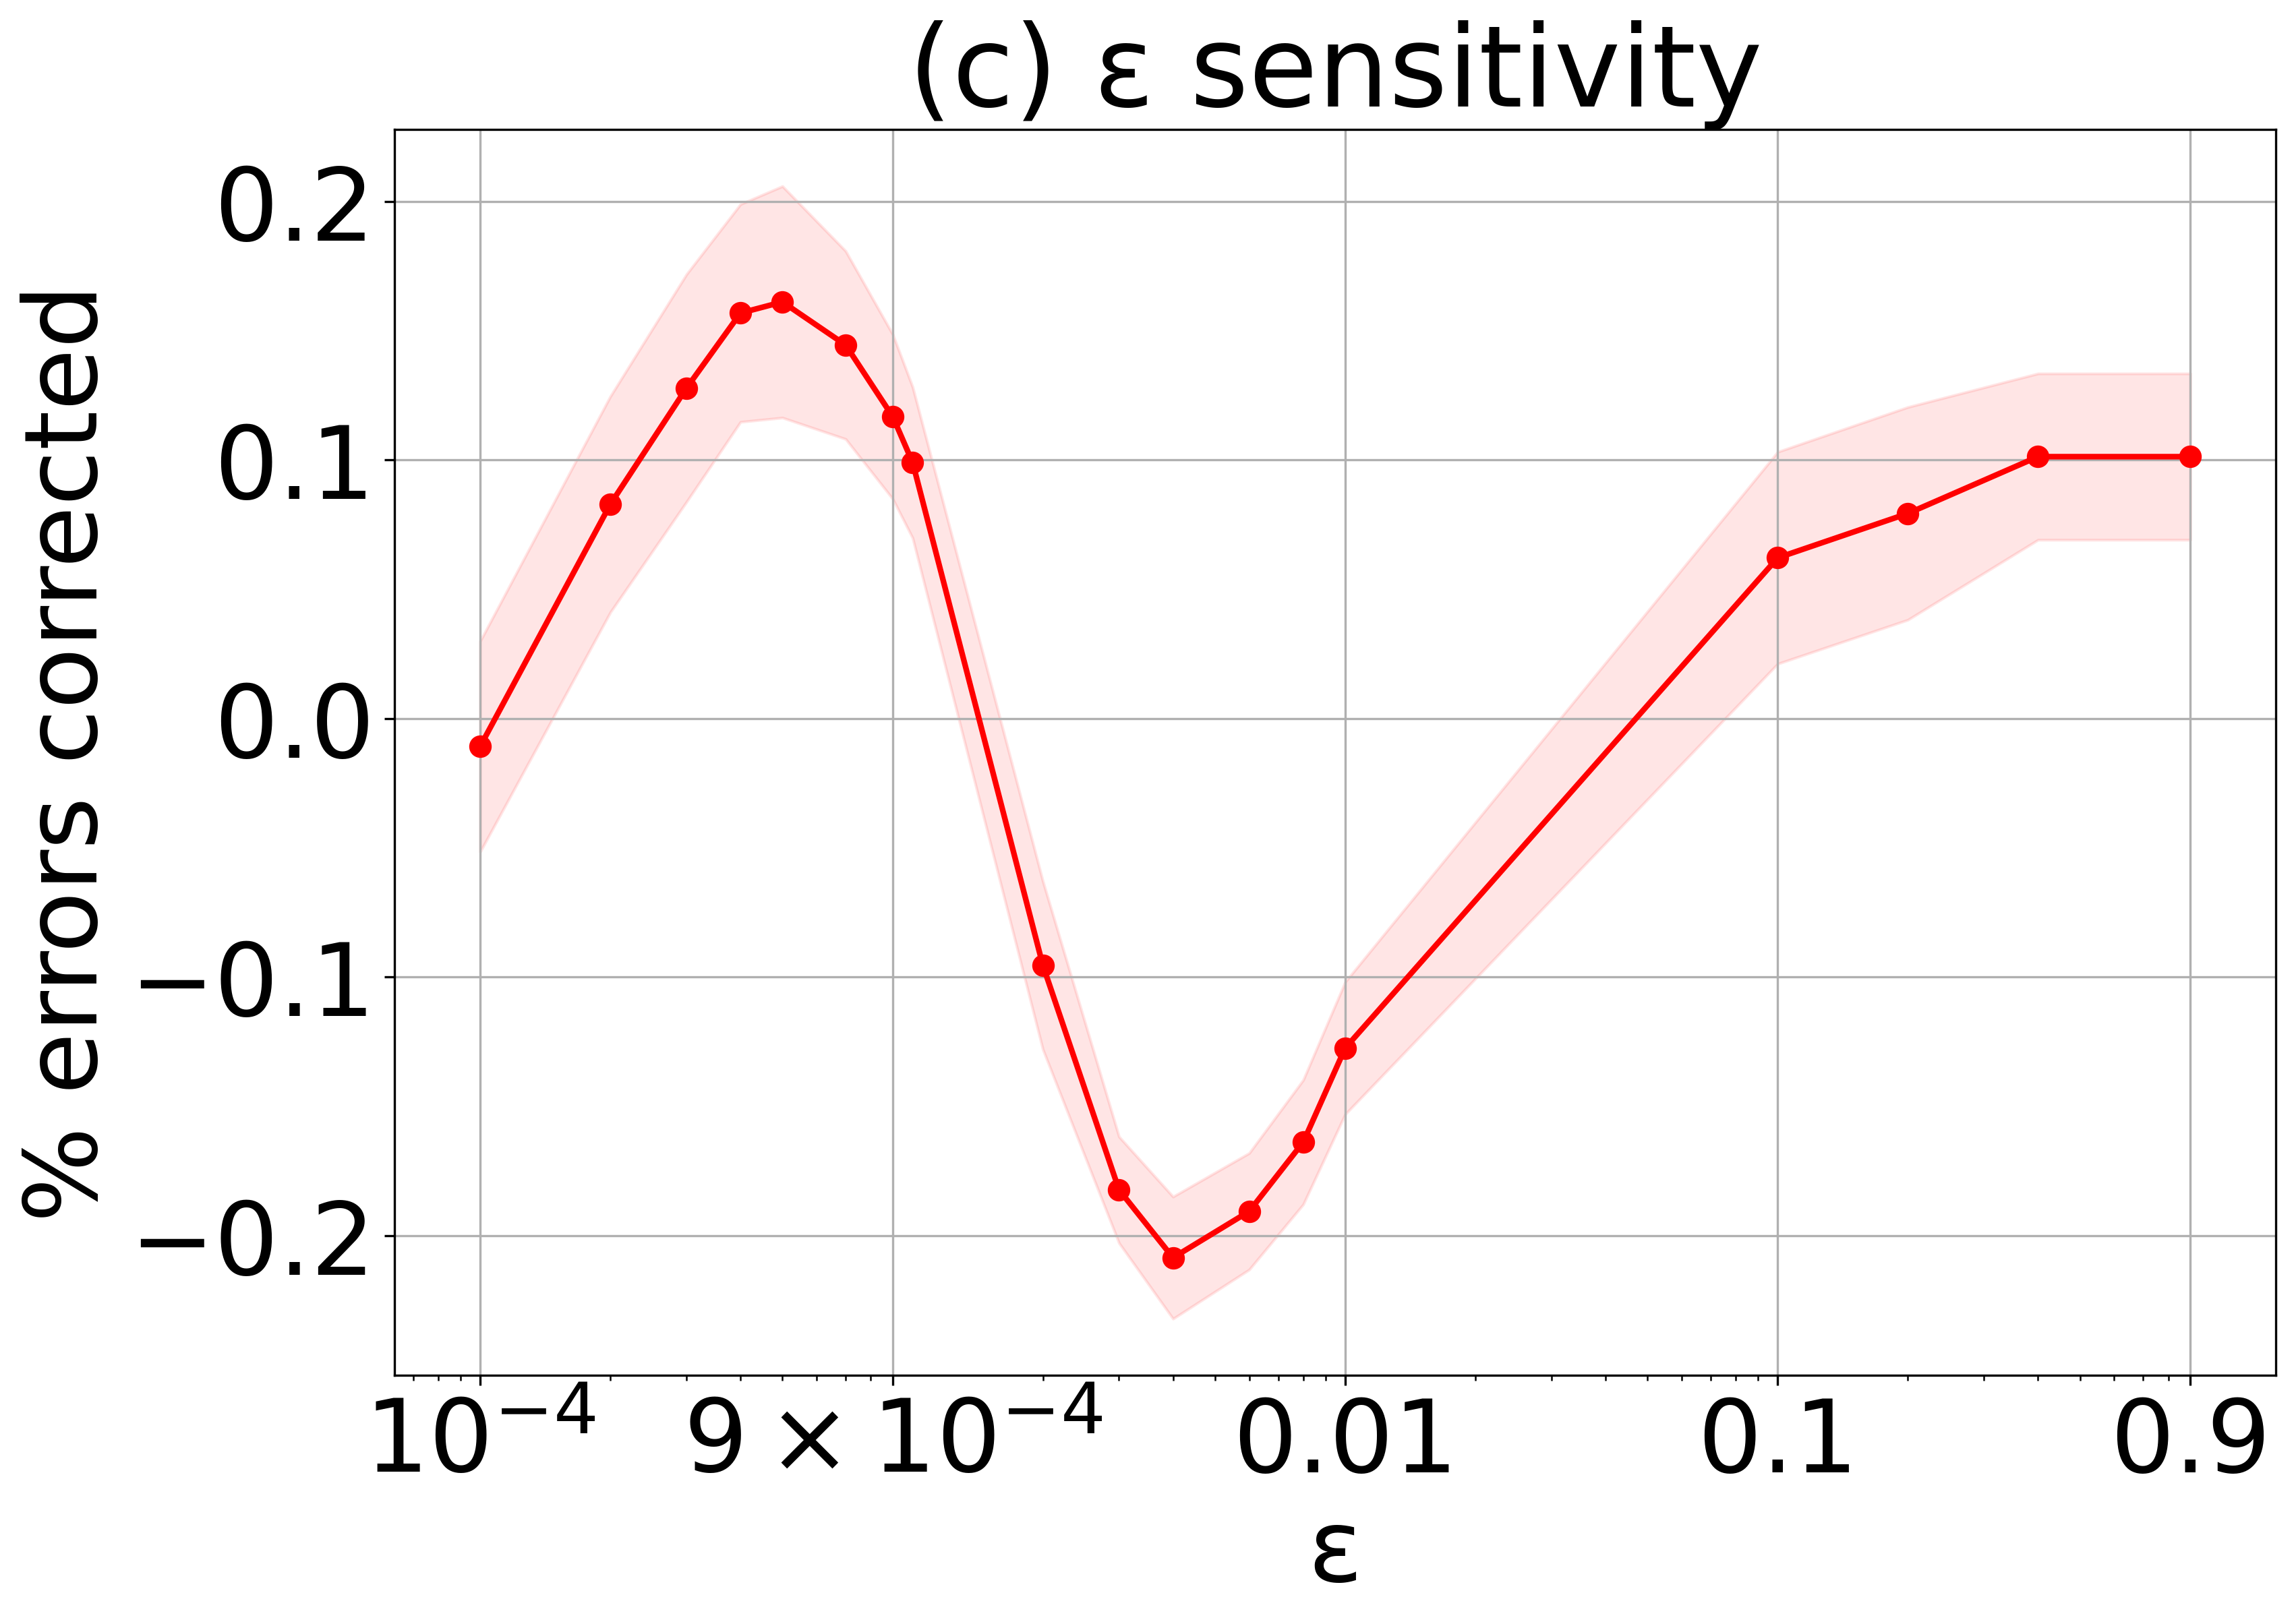

In [34]:
#@title Eps sensitive
log_paths = [
    "logs\\epsilon_sensitive\\240414_072157.json",
    "logs\\epsilon_sensitive\\240414_074846.json",
    "logs\\epsilon_sensitive\\240414_081401.json",
    "logs\\epsilon_sensitive\\240414_084044.json",
    "logs\\epsilon_sensitive\\240414_090756.json",
    "logs\\epsilon_sensitive\\240414_093559.json",
    "logs\\epsilon_sensitive\\240414_100220.json",
    "logs\\epsilon_sensitive\\240414_103043.json",
    "logs\\epsilon_sensitive\\240414_105349.json",
    "logs\\epsilon_sensitive\\240414_111905.json"
]
exp_name = "epsilon_sensitive"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
eps_range = [0.0001 * i for i in range(1, 10)] + [0.001 * i for i in range(1, 10)] + [0.01 * i for i in range(1, 10)] + [0.1 * i for i in range(1, 10)]
include_inds = [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 14, 16, 18, 27, 28, 30, 35]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 1
x_axis, y_axis = 'eps', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        np.array(record_[x_axis][0])[include_inds],
        (y - moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window))[include_inds],
        (y + moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window))[include_inds],
        alpha=0.1,
        color=colors[i],
    )

plt.title("(c) " + u"\u03B5" + " sensitivity", fontsize=40)
plt.xlabel(u"\u03B5", fontsize=36)
plt.ylabel("% errors corrected", fontsize=36)
plt.xscale('log')
plt.xticks([0.0001, 0.0009, 0.01, 0.1, 0.9],
           [fr"$10^{{{-4}}}$", 
            fr"$9\times10^{{{-4}}}$", 0.01, 0.1, 0.9], fontsize=36)
plt.yticks(fontsize=36)
#plt.legend()
plt.grid(True)
plt.show()

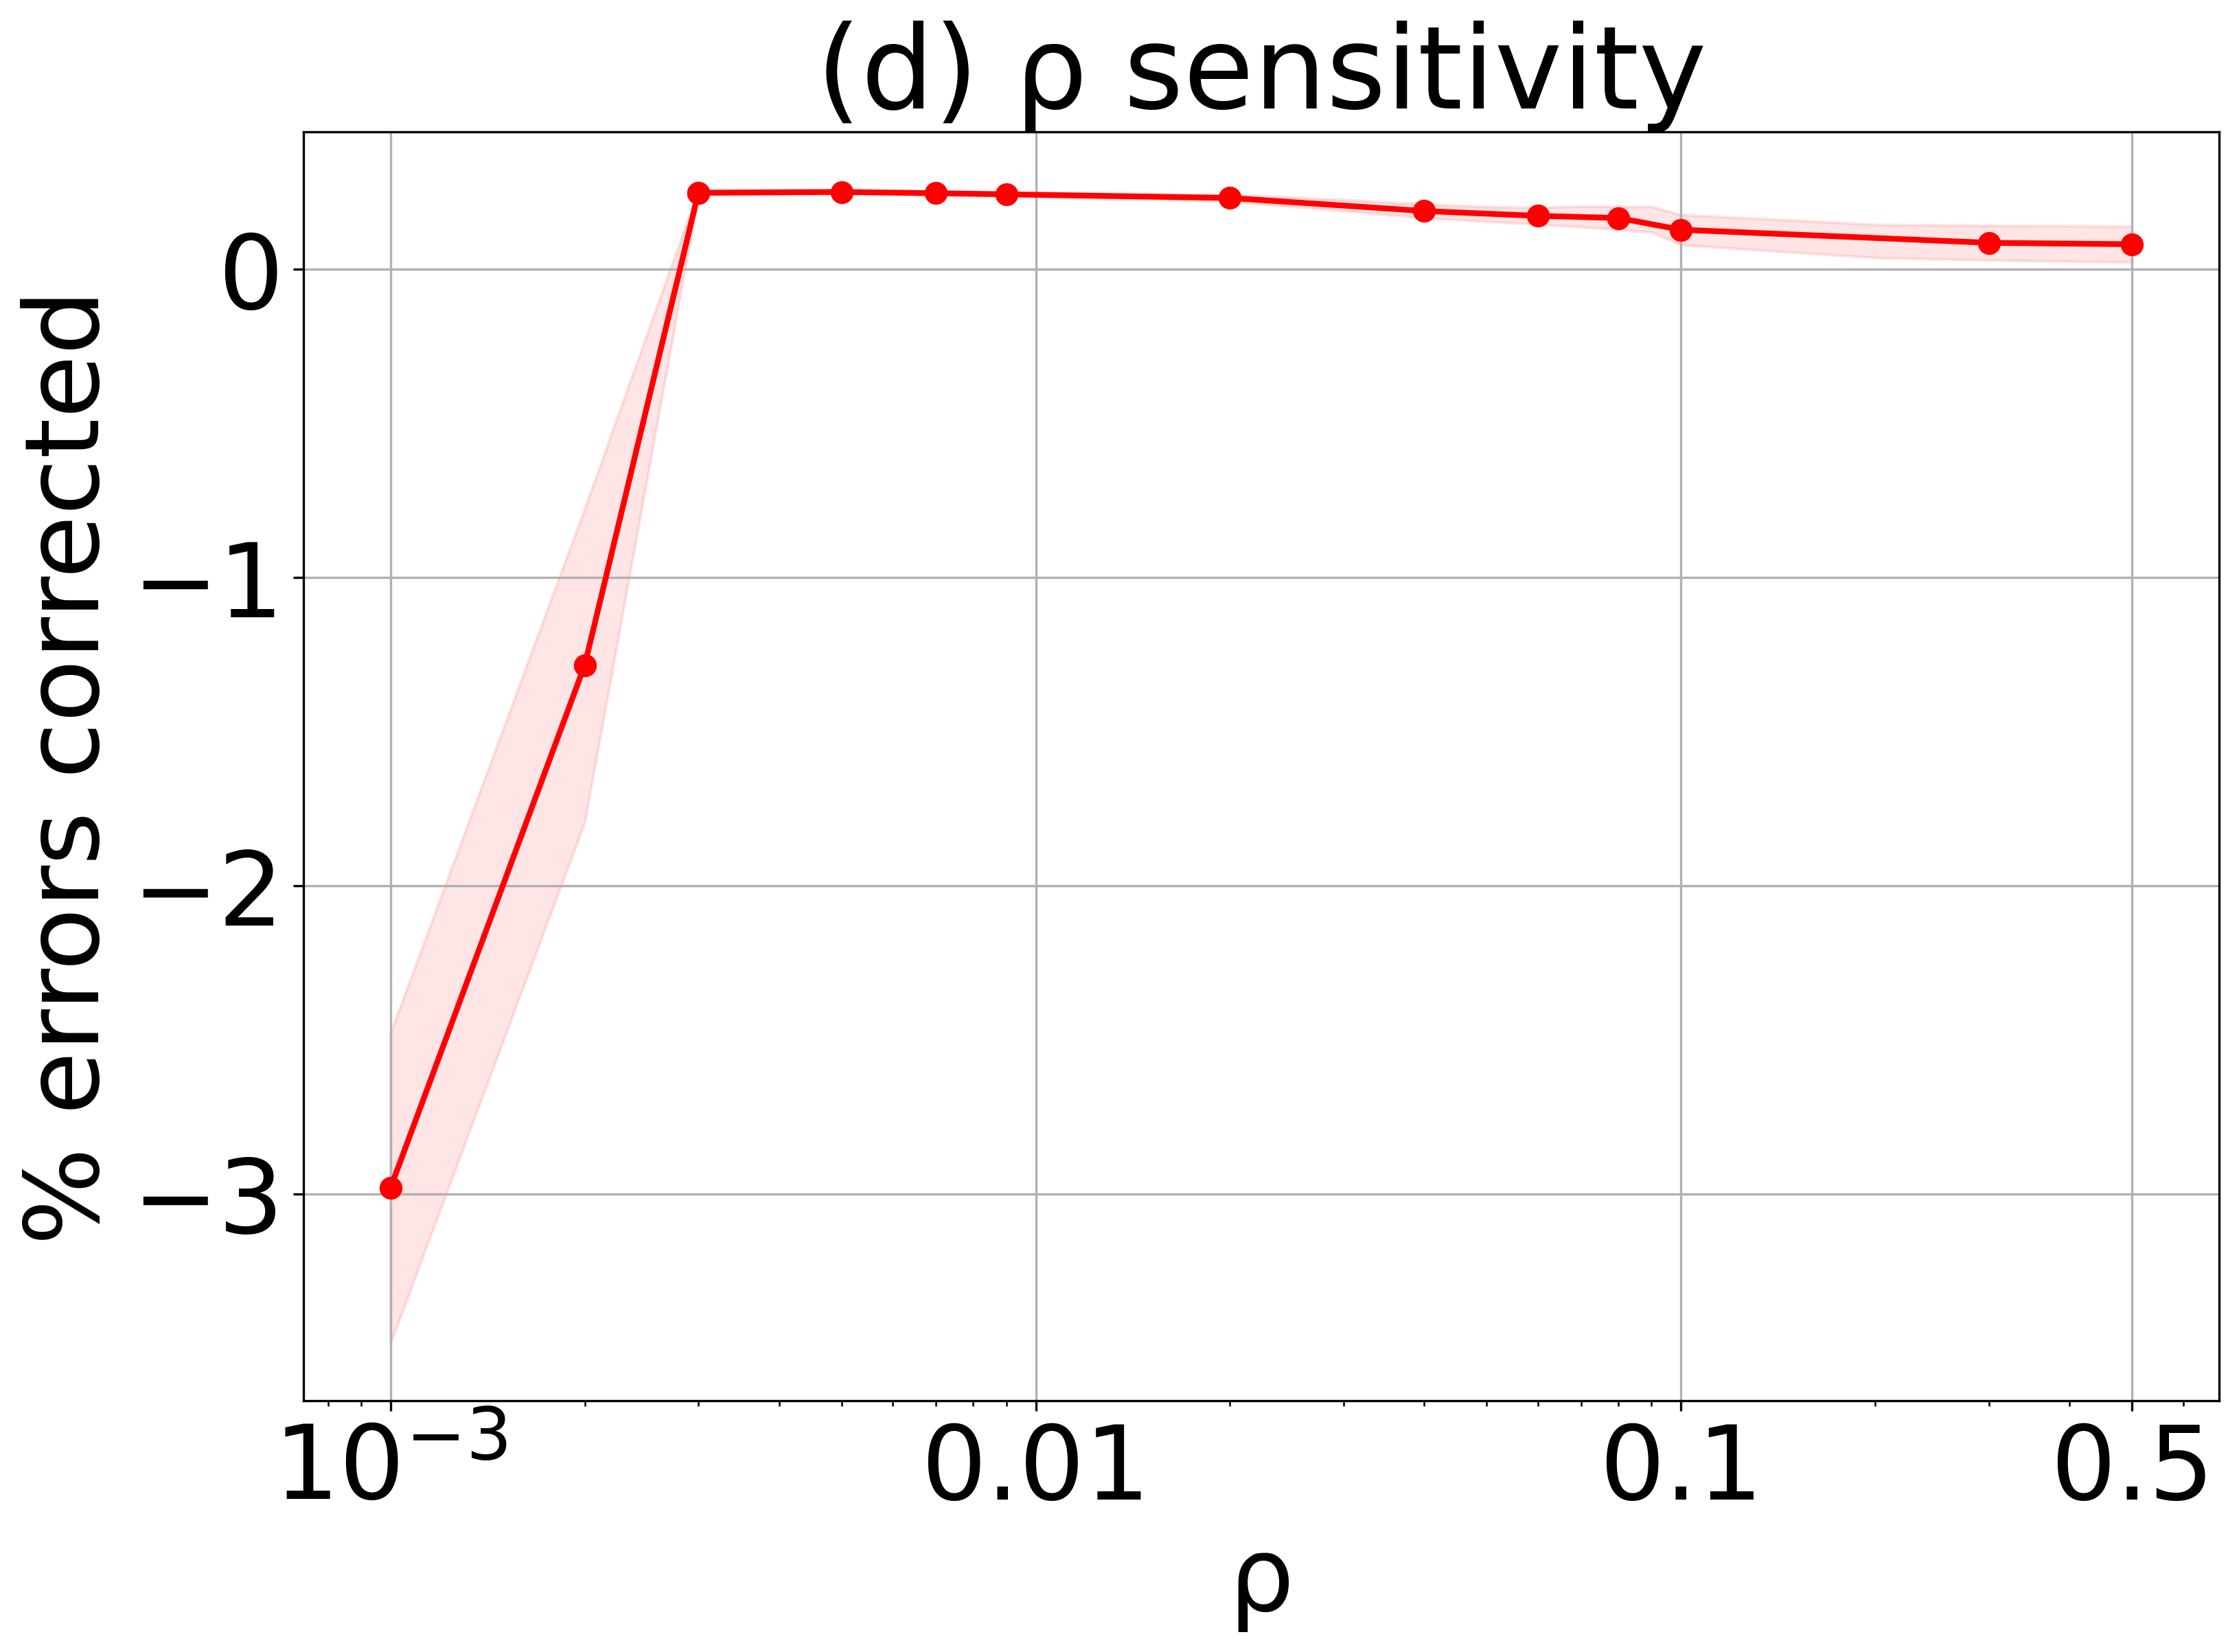

In [35]:
#@title Rho sensitive
log_paths = [
    "logs\\rho_sensitive\\240416_050601.json",
    "logs\\rho_sensitive\\240416_051723.json",
    "logs\\rho_sensitive\\240416_053133.json",
    "logs\\rho_sensitive\\240416_054220.json",
    "logs\\rho_sensitive\\240416_055339.json",
    "logs\\rho_sensitive\\240416_060814.json",
    "logs\\rho_sensitive\\240416_062003.json",
    "logs\\rho_sensitive\\240416_063328.json",
    "logs\\rho_sensitive\\240416_064444.json",
    "logs\\rho_sensitive\\240416_070611.json"
]
exp_name = "rho_sensitive"
records = []
for path in log_paths:
    records.append(Experiment.load(path))
summary = summarize(
    exp_name=exp_name,
    records=records,
    y_axis="accuracy"
)
rho_range= [0.001 * i for i in range(1, 10)] + [0.01 * i for i in range(1, 10)] + [0.1 * i for i in range(1, 6)]
include_inds = [0, 1, 2] + [i * 2 for i in range(1, len(rho_range) // 2 + 1)]

markers = ["o", "*", "s", "+"]
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "green", "gray"]
window = 2
x_axis, y_axis = 'rho', 'delta_acc'
plt.figure(figsize=(12, 8))
for i, (algo, record_) in enumerate(summary[exp_name].items()):
    y = moving_average((np.array(record_["summary"][y_axis + "_mean"])).tolist(), window)
    plt.plot(
        np.array(record_[x_axis][0])[include_inds], 
        np.array(y)[include_inds], 
        label=algo_id[algo],
        color=colors[i],
        marker=markers[i],
        linestyle=linestyles[i],
        linewidth=2,
        markersize=7
    )
    plt.fill_between(
        np.array(record_[x_axis][0]),
        (y - moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window)),
        (y + moving_average((np.array(record_["summary"][y_axis + "_std"])).tolist(), window)),
        alpha=0.1,
        color=colors[i],
    )

plt.title("(d) " + u"\u03C1" + " sensitivity", fontsize=40)
plt.xlabel(u"\u03C1", fontsize=36)
plt.ylabel("% errors corrected", fontsize=36)
plt.xscale('log')
plt.xticks([0.001, 0.01, 0.1, 0.5], 
           [fr"$10^{{{-3}}}$", 0.01, 0.1, 0.5], fontsize=36)
plt.yticks([-3, -2, -1, 0], fontsize=36)
#plt.legend(fontsize=18)
plt.grid(True)
plt.show()